In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import plotly.express as px
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
tqdm.pandas()
np.random.seed(42)

In [3]:
mails = pd.read_json('data/mails_preprocessing.json').drop('from', axis = 1)
print(mails.shape)
mails.head()

(8564, 21)


,label,text,_questionmark_count_,text_lem,_AJD_count_,_ADP_count_,_ADV_count_,_AUX_count_,_CCONJ_count_,_DET_count_,...,_NOUN_count_,_NUM_count_,_PRON_count_,_PROPN_count_,_PUNCT_count_,_SCONJ_count_,_SYM_count_,_VERB_count_,_X_count_,unique_words_count
0,1,acces decibel bonjour pouvez vous donner les a...,2,acce decibel bonjour pouvoir donner acces deci...,0,7,1,1,0,3,...,18,2,3,0,2,0,0,3,1,233
1,1,actes indemnités hospitalières tu sais ce que ...,2,acte indemnite hospitalier savoir acte frais r...,0,3,3,0,2,5,...,12,2,5,0,2,1,0,6,0,177
2,1,analyse des obsèques naissances appareils audi...,1,analyse obseque naissance appareil auditif bon...,0,6,3,0,2,6,...,23,1,8,0,4,3,0,8,0,274
3,1,ano ihm bonjour j ai un multivalue filtres eta...,1,ano ihm bonjour multivalu filtre etablissement...,0,2,1,0,1,2,...,11,1,1,0,1,0,0,2,3,172
4,1,ano alimentation réseau sur dcb bonjour je m i...,1,ano alimentation reseau dob bonjour metre inte...,0,38,6,6,2,31,...,56,3,14,1,10,1,0,20,0,659


# Word2Vec

In [5]:
sentences = [str(sentence).split(' ') for sentence in mails.text_lem]
bigram = Phrases(sentences)
sentences = [bigram[line] for line in sentences]
sentences = [bigram[line] for line in sentences]

In [ ]:
w2v = Word2Vec(sentences, min_count=1, sg=1, workers=6, vector_size=500, epochs=500)

In [19]:
w2v.wv.save_word2vec_format('models/w2v_model.bin', binary=True)

In [ ]:
tokens = [w2v.wv[word] for word in w2v.wv.key_to_index]
w2v.wv.most_similar('decibel')

# Doc2Vec

In [7]:
texts = mails.text_lem.values.copy()
texts = [[word for word in doc.split(' ') if word != 're'] for doc in texts]
bigram = Phrases(texts)
texts = [bigram[line] for line in texts]
texts = [bigram[line] for line in texts]

In [8]:
sentences = [TaggedDocument(sentence, [i]) for i,sentence in enumerate(texts)]
d2v = Doc2Vec(sentences, min_count = 1, dm = 1, workers = 6, vector_size=500, window = 10, epochs=500)
#d2v.wv.save_word2vec_format('models/d2v_model.bin', binary=True)

In [9]:
d2v_wv = d2v.wv
#d2v_wv = KeyedVectors.load_word2vec_format('models/d2v_model.bin', binary=True)

In [15]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=500, random_state=23)
result = tsne_model.fit_transform(tokens)

In [16]:
# creating a dataframe from the results
df = pd.DataFrame(result, columns=['X','Y'])
# adding a columns for the corresponding words
df['Words'] = [word for word in d2v_wv.key_to_index]
# converting the lower case text to title case
df['Words'] = df['Words'].str.title()

# plotting a scatter plot
fig = px.scatter(df, x="X", y="Y", text="Words", log_x=True, size_max=60)
# adjusting the text position
fig.update_traces(textposition='top center')
# setting up the height and title
fig.update_layout(
    height=600,
    title_text='Word embedding chart'
)
# displaying the figure
fig.show()

In [17]:
def FunctionText2Vec(input_df, word2vec_wv, input_col='text_lem'):
    # Converting the text to numeric data
    X = [str(sentence).split(' ') for sentence in input_df[input_col]]
    
    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()
    
    # Looping through each row for the data
    for sentence in X:
 
        # initiating a sentence with all zeros
        Embedded_sentence = np.zeros(word2vec_wv.vector_size)
 
        for word in sentence:
            if word in word2vec_wv.key_to_index.keys():    
                Embedded_sentence = Embedded_sentence + word2vec_wv[word]
        Embedded_sentence.reshape(1, word2vec_wv.vector_size)
        # Embedded_sentence = model.infer_vector(sentence)
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Embedded_sentence]))

    return W2Vec_Data

In [18]:
word_embedding = FunctionText2Vec(mails, d2v_wv, "text_lem")

In [21]:
df_features = mails.iloc[:,3::].drop('text_lem', axis = 1)
word_embedding.reset_index(inplace=True, drop=True)
word_embedding['_label_'] = mails['label']
df = pd.concat([df_features, word_embedding], axis = 1)
df.head()

,_questionmark_count_,_AJD_count_,_ADP_count_,_ADV_count_,_AUX_count_,_CCONJ_count_,_DET_count_,_INTJ_count_,_NOUN_count_,_NUM_count_,...,491,492,493,494,495,496,497,498,499,_label_
0,2,0,7,1,1,0,3,0,18,2,...,7.552959,-7.758190,-17.432704,7.485336,-6.116660,5.172562,7.584496,5.250462,-1.320692,1
1,2,0,3,3,0,2,5,0,12,2,...,-7.110094,-5.106038,-6.896137,-6.444591,4.211719,10.020246,-0.814034,-3.377685,1.531344,1
2,1,0,6,3,0,2,6,0,23,1,...,-12.163507,5.605024,-18.668275,-20.377143,-3.610264,0.414532,-11.114808,-3.477304,-4.977881,1
3,1,0,2,1,0,1,2,0,11,1,...,2.105754,-1.297430,-9.423036,-1.073635,8.888151,6.058524,4.917495,7.490066,-1.712665,1
4,1,0,38,6,6,2,31,0,56,3,...,-19.045707,-35.856213,-24.074799,-23.920559,16.694527,10.680893,-16.323111,40.139483,-10.349179,1


In [22]:
pd.to_pickle(df, 'data/mails_embedded_doc2vec_bigrams.pkl')

# Application à la classification

In [94]:
#word2vec_wv = KeyedVectors.load_word2vec_format('models/w2v_model.bin', binary=True)

In [2]:
word_embedding = pd.read_pickle('data/mails_embedded_doc2vec_bigrams.pkl')
word_embedding.head()

,_questionmark_count_,_AJD_count_,_ADP_count_,_ADV_count_,_AUX_count_,_CCONJ_count_,_DET_count_,_INTJ_count_,_NOUN_count_,_NUM_count_,...,491,492,493,494,495,496,497,498,499,_label_
0,2,0,7,1,1,0,3,0,18,2,...,7.552959,-7.758190,-17.432704,7.485336,-6.116660,5.172562,7.584496,5.250462,-1.320692,1
1,2,0,3,3,0,2,5,0,12,2,...,-7.110094,-5.106038,-6.896137,-6.444591,4.211719,10.020246,-0.814034,-3.377685,1.531344,1
2,1,0,6,3,0,2,6,0,23,1,...,-12.163507,5.605024,-18.668275,-20.377143,-3.610264,0.414532,-11.114808,-3.477304,-4.977881,1
3,1,0,2,1,0,1,2,0,11,1,...,2.105754,-1.297430,-9.423036,-1.073635,8.888151,6.058524,4.917495,7.490066,-1.712665,1
4,1,0,38,6,6,2,31,0,56,3,...,-19.045707,-35.856213,-24.074799,-23.920559,16.694527,10.680893,-16.323111,40.139483,-10.349179,1


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
plt.style.use('ggplot')

In [4]:
X_unlabeled = word_embedding[word_embedding['_label_'] == 2].drop('_label_', axis = 1)
X, y = word_embedding[word_embedding['_label_'] != 2].drop('_label_', axis = 1), word_embedding[word_embedding['_label_'] != 2]._label_

In [5]:
X, X_test, y, y_test = train_test_split(X,y,test_size=0.2, stratify = y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state = 42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
class_weigth = compute_class_weight('balanced', classes = [0,1], y = y_train.values)
class_weigth = {key:val for key,val in zip([0,1], class_weigth)}

In [9]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(class_weight=class_weigth, random_state = 42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.43      0.49       142
           1       0.93      0.96      0.95      1142

    accuracy                           0.90      1284
   macro avg       0.75      0.70      0.72      1284
weighted avg       0.89      0.90      0.90      1284



In [12]:
from sklearn.svm import SVC
svc = SVC(C = 0.1325, class_weight = class_weigth, random_state = 42)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.76      0.68       142
           1       0.97      0.94      0.95      1142

    accuracy                           0.92      1284
   macro avg       0.79      0.85      0.81      1284
weighted avg       0.93      0.92      0.92      1284



In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = 'newton-cg', class_weight=class_weigth)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       142
           1       0.98      0.98      0.98      1142

    accuracy                           0.97      1284
   macro avg       0.91      0.93      0.91      1284
weighted avg       0.97      0.97      0.97      1284



In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.67      0.77       142
           1       0.96      0.99      0.98      1142

    accuracy                           0.96      1284
   macro avg       0.94      0.83      0.87      1284
weighted avg       0.96      0.96      0.95      1284



In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, metric = 'cosine')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.71      0.80       142
           1       0.97      0.99      0.98      1142

    accuracy                           0.96      1284
   macro avg       0.93      0.85      0.89      1284
weighted avg       0.96      0.96      0.96      1284



# Importance des variables

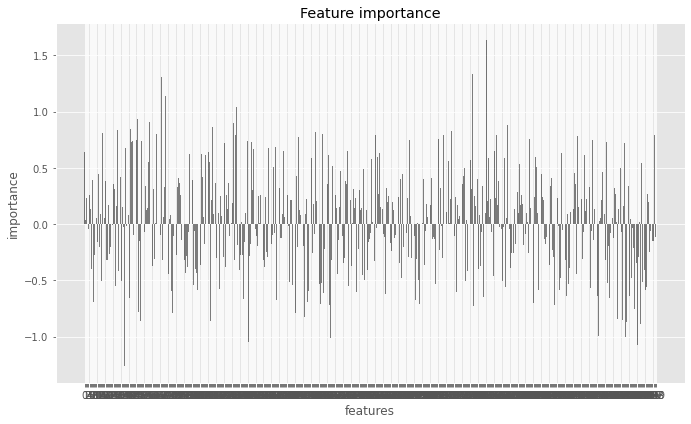

In [33]:
import numpy as np
import matplotlib.pyplot as plt

cols = word_embedding.drop('_label_', axis = 1).columns
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(cols))
bar_width = 0.35
plt.bar(index, lr.coef_[0], color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index + bar_width, cols)
plt.tight_layout()
plt.show()

# Subsampling

In [34]:
x1 = word_embedding[word_embedding._label_==0].sample(590, random_state = 42)
y1 = x1._label_
x1 = x1.drop('_label_', axis = 1)
x2 = word_embedding[word_embedding._label_==1].sample(590, random_state = 42)
y2 = x2._label_
x2 = x2.drop('_label_', axis = 1)
Xt = np.concatenate([x1,x2])
yt = np.concatenate([y1, y2])

Xt, X_test, yt, y_test = train_test_split(Xt, yt, test_size=0.2, stratify = yt, random_state = 42)
Xt_train, Xt_val, yt_train, yt_val = train_test_split(Xt, yt, test_size=0.2, stratify = yt, random_state = 42)

In [36]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(Xt_train, yt_train)

y_pred = tree.predict(Xt_val)
print(classification_report(yt_val, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76        95
           1       0.75      0.80      0.77        94

    accuracy                           0.77       189
   macro avg       0.77      0.77      0.77       189
weighted avg       0.77      0.77      0.77       189



In [40]:
from sklearn.svm import SVC
svc = SVC(C = 0.1325, random_state = 42)
svc.fit(Xt_train, yt_train)

y_pred = svc.predict(Xt_val)
print(classification_report(yt_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71        95
           1       0.70      0.86      0.77        94

    accuracy                           0.75       189
   macro avg       0.76      0.75      0.74       189
weighted avg       0.76      0.75      0.74       189



In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = 'newton-cg', random_state = 42)
lr.fit(Xt_train, yt_train)

y_pred = lr.predict(Xt_val)
print(classification_report(yt_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86        95
           1       0.87      0.85      0.86        94

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189



In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xt_train, yt_train)

y_pred = knn.predict(Xt_val)
print(classification_report(yt_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        95
           1       0.81      0.85      0.83        94

    accuracy                           0.83       189
   macro avg       0.83      0.83      0.83       189
weighted avg       0.83      0.83      0.83       189



In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, metric = 'cosine')
knn.fit(Xt_train, yt_train)

y_pred = knn.predict(Xt_val)
print(classification_report(yt_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        95
           1       0.87      0.84      0.85        94

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189

